Install openpyxl if not installed to be able to read excel files:

``` python
pip install openpyxl
pip install sympy
```

In [1]:
import os
import pandas as pd
from sympy import symbols, Eq, solve
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from matplotlib.collections import PathCollection

params_dict = {
    'font.size' : 12,
    'axes.labelsize': 'medium',
    'xtick.top' : True,
    'ytick.right' : True,
    'axes.labelsize' : 16,
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'xtick.top' : True,
    'ytick.right' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'legend.frameon' : True,
    'svg.fonttype' : 'none',
    'pdf.fonttype' : 42,
    'savefig.transparent' : True
}
plt.rcParams.update(params_dict)
save_dir = os.path.join(os.getcwd(), 'figs_python')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(f' Figures will be saved in this folder:\n {save_dir}')

 Figures will be saved in this folder:
 \\cifs1.bpcentral.biophys.mpg.de\msdata\kimlab\SMC56LoopingProject\Manuscript\Nature\ResearchData\figs_python


## All_data_label

In [2]:
excel_all_data_label = pd.ExcelFile('All_data_label_BP.xlsx')

excel_all_data_label.sheet_names

['WT_2nM_100mM_NaCl_7p5mM_MgCl2',
 'Nse4SNAP_Alexa640',
 'Nse4SNAP_Alexa640_NonLoop',
 'Nse4SNAP_Alexa640_side_flow',
 'Side_flow',
 'Looping_fraction',
 'DnaLengthNonLoops',
 'DnaLengthLoops',
 'DnaLength']

### Looping with labeled SMC5/6

In [3]:
data_label_loop = excel_all_data_label.parse('Nse4SNAP_Alexa640')
data_label_loop = data_label_loop[data_label_loop['Name'].notna()]
data_label_loop.head()

,Name,X,Y,W,H,co-localization protein and loop start?,binding?,bleaching?,how many molecules?,DeltaT1,DeltaT2,frame duration,frame range,comments,folderpath,Rate,Unnamed: 16
0,loop,1.65781,12.711597,6.296547,4.352076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,loop from the start,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN,NaN
1,no loop,33.542373,27.190141,10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN,NaN
2,loop (2),41.736341,12.104344,5.64648,4.197738,yes,yes,yes,2.0,22.0,423.0,1480.0,1471-2953,"short end-to-end, short binding",20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN,NaN
3,loop (3),29.70676,18.178587,8.260428,3.798492,NaN,yes,yes,NaN,NaN,NaN,NaN,NaN,directional translocations,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN,NaN
4,loop (4),64.250965,30.412626,6.644594,4.99623,yes,yes,yes,2.0,50.0,247.0,4150.0,851-5000,"short end-to-end, Loop initiation on binding o...",20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN,NaN


### Functions to extract and plot

In [4]:
def count_molecules_from_df_excel(data_label_loop):
    df_label_loop_NO_molecules = data_label_loop[data_label_loop['co-localization protein and loop start?']=='no']
    # N_col = len(data_label_loop[data_label_loop['co-localization protein and loop start?']=='yes'])
    df_label_loop_molecules = data_label_loop[data_label_loop['how many molecules?'].notna()] # rows containing definite number of molecules
    df_label_loop_1_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==1]
    df_label_loop_2_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==2]
    df_label_loop_agg_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?'] > 2]

    N_tot = len(df_label_loop_molecules) + len(df_label_loop_NO_molecules)
    N_no_col = len(df_label_loop_NO_molecules)
    N_col = len(df_label_loop_molecules)
    N_1bleaching = len(df_label_loop_1_molecules)
    N_2bleaching = len(df_label_loop_2_molecules)
    N_aggbleaching = len(df_label_loop_agg_molecules)
    results = {
        'labels' : ['No labels', '1 Step', '2 Step', '>2 Step'],
        'values' : [N_no_col, N_1bleaching, N_2bleaching, N_aggbleaching],
        'total' : N_tot,
        'N_col' : N_col,
        'N_no_col' : N_no_col,
        'N_1bleaching' : N_1bleaching,
        'N_2bleaching' : N_2bleaching,
        'N_aggbleaching' : N_aggbleaching,
    }
    return results

def error_calc(values, total, norm=100):
    values_arr = np.array(values)
    fractions = values_arr/total
    fractions = values_arr/total
    fractions_err = norm * (1/total) * np.sqrt(total * fractions * (1 - fractions))
    return fractions, fractions_err

def barstat_err_plot(labels, values, total,
            ax=None, width = 0.2, shift=0, norm=100, label='Fractions', e_color=None, hatch="/"):
    '''
    labels and values as list of same length
    total: total events
    '''
    x_ticks = 0.25*np.arange(1, 1+len(labels))
    fractions, fractions_err = error_calc(values, total, norm=norm)
    print(f'error: {fractions_err}')
    fractions = norm * fractions # convert into percentage
    if ax is None:
        fig, ax = plt.subplots(figsize=(3,4))
    ax.bar(x_ticks+shift, fractions, width, color=e_color,alpha=0.8, hatch=hatch, label=label)
    ax.errorbar(x_ticks+shift, fractions, yerr=fractions_err, fmt='*', capsize=5, ecolor="k", mfc="k", label='')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(labels, fontsize=12)
    # ax.set_ylim(0, 100)
    ax.set_ylabel('fractions (%)')
    return ax

### All Molecules

error: [2.49322544 2.7562172  2.88202816 0.83302603]
Number of total events::::::::::::::::::::::::::::::291
Number of events with colocalization::::::::::::::::222, (0.76)
Number of events withut colocalization::::::::::::::69, (0.24)
Number of events with 1 bleaching step (molecule):::96, (0.33)
Number of events with 2 bleaching step (molecules)::119, (0.41)
Number of events with >2 bleaching step (molecules):6, (0.02)



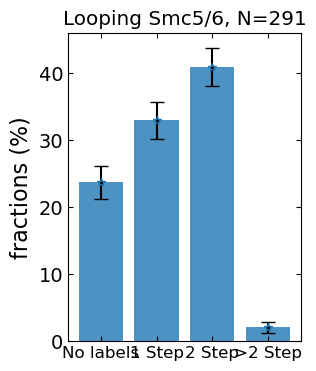

In [5]:
results = count_molecules_from_df_excel(data_label_loop)
ax = barstat_err_plot(results['labels'], results['values'], results['total'], hatch=None)
tot = results['total']
ax.set_title(f'Looping Smc5/6, N={tot}')

N_tot, N_col, N_no_col, N_1bleaching, N_2bleaching, N_aggbleaching = results['total'], results['N_col'], results['N_no_col'], results['N_1bleaching'], results['N_2bleaching'], results['N_aggbleaching']
print(f'\
Number of total events::::::::::::::::::::::::::::::{N_tot}\n\
Number of events with colocalization::::::::::::::::{N_col}, ({round(N_col/N_tot, 2)})\n\
Number of events withut colocalization::::::::::::::{N_no_col}, ({round(N_no_col/N_tot, 2)})\n\
Number of events with 1 bleaching step (molecule):::{N_1bleaching}, ({round(N_1bleaching/N_tot, 2)})\n\
Number of events with 2 bleaching step (molecules)::{N_2bleaching}, ({round(N_2bleaching/N_tot, 2)})\n\
Number of events with >2 bleaching step (molecules):{N_aggbleaching}, ({round(N_aggbleaching/N_tot, 2)})\n\
')

### 5nM

In [6]:
print(f'5nM: fraction translocating and looping: {8/134}') # 5nM: translocating and looping afterwards
print(f'2nM: fraction translocating and looping: {4/72}')
print(f'0.5nM: fraction translocating and looping: {4/72}')
 # 2nM: translocating and looping afterwards


5nM: fraction translocating and looping: 0.05970149253731343
2nM: fraction translocating and looping: 0.05555555555555555
0.5nM: fraction translocating and looping: 0.05555555555555555


C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\540463910.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_1|imgs_2|imgs_3|imgs_5)')]


error: [4.13590325 4.84381483 5.18197455 1.85171391]
Number of total events::::::::::::::::::::::::::::::92
Number of events with colocalization::::::::::::::::74, (0.8)
Number of events withut colocalization::::::::::::::18, (0.2)
Number of events with 1 bleaching step (molecule):::29, (0.32)
Number of events with 2 bleaching step (molecules)::41, (0.45)
Number of events with >2 bleaching step (molecules):3, (0.03)



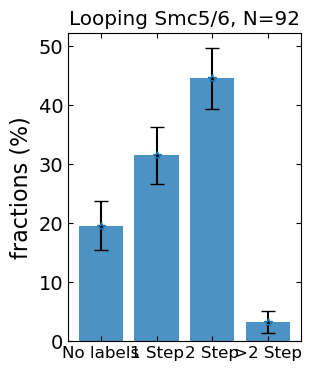

In [7]:
df_all = data_label_loop
df_filt_temp = df_all[df_all['folderpath'].notna()]
df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('_5nM')]
df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_1|imgs_2|imgs_3|imgs_5)')]
df_filt_5nM = df_filt_temp
results = count_molecules_from_df_excel(df_filt_temp)
results_5nM = results

ax = barstat_err_plot(results['labels'], results['values'], results['total'], hatch=None)
tot = results['total']
ax.set_title(f'Looping Smc5/6, N={tot}')

N_tot, N_col, N_no_col, N_1bleaching, N_2bleaching, N_aggbleaching = results['total'], results['N_col'], results['N_no_col'], results['N_1bleaching'], results['N_2bleaching'], results['N_aggbleaching']
print(f'\
Number of total events::::::::::::::::::::::::::::::{N_tot}\n\
Number of events with colocalization::::::::::::::::{N_col}, ({round(N_col/N_tot, 2)})\n\
Number of events withut colocalization::::::::::::::{N_no_col}, ({round(N_no_col/N_tot, 2)})\n\
Number of events with 1 bleaching step (molecule):::{N_1bleaching}, ({round(N_1bleaching/N_tot, 2)})\n\
Number of events with 2 bleaching step (molecules)::{N_2bleaching}, ({round(N_2bleaching/N_tot, 2)})\n\
Number of events with >2 bleaching step (molecules):{N_aggbleaching}, ({round(N_aggbleaching/N_tot, 2)})\n\
')
plt.savefig(os.path.join(save_dir, 'fractions_steps_all.svg'))

### 2 nM

error: [7.33212111 9.32952303 9.92773892 5.42586399]
Number of total events::::::::::::::::::::::::::::::25
Number of events with colocalization::::::::::::::::21, (0.84)
Number of events withut colocalization::::::::::::::4, (0.16)
Number of events with 1 bleaching step (molecule):::8, (0.32)
Number of events with 2 bleaching step (molecules)::11, (0.44)
Number of events with >2 bleaching step (molecules):2, (0.08)



C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3841711300.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_1|imgs_2|imgs_3)')]


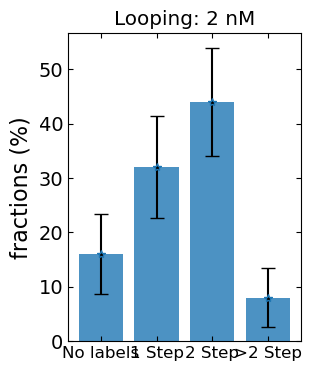

In [8]:
df_all = data_label_loop
df_filt_temp = df_all[df_all['folderpath'].notna()]
df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('_2nM')]
df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_1|imgs_2|imgs_3)')]
df_filt_2nM = df_filt_temp

results = count_molecules_from_df_excel(df_filt_temp)
results_2nM = results # IMP rename the results

ax = barstat_err_plot(results['labels'], results['values'], results['total'], hatch=None)
ax.set_title('Looping: 2 nM')

N_tot, N_col, N_no_col, N_1bleaching, N_2bleaching, N_aggbleaching = results['total'], results['N_col'], results['N_no_col'], results['N_1bleaching'], results['N_2bleaching'], results['N_aggbleaching']
print(f'\
Number of total events::::::::::::::::::::::::::::::{N_tot}\n\
Number of events with colocalization::::::::::::::::{N_col}, ({round(N_col/N_tot, 2)})\n\
Number of events withut colocalization::::::::::::::{N_no_col}, ({round(N_no_col/N_tot, 2)})\n\
Number of events with 1 bleaching step (molecule):::{N_1bleaching}, ({round(N_1bleaching/N_tot, 2)})\n\
Number of events with 2 bleaching step (molecules)::{N_2bleaching}, ({round(N_2bleaching/N_tot, 2)})\n\
Number of events with >2 bleaching step (molecules):{N_aggbleaching}, ({round(N_aggbleaching/N_tot, 2)})\n\
')

### 0.5 nM

error: [4.81859132 6.83660645 6.98927677 0.        ]
Number of total events::::::::::::::::::::::::::::::51
Number of events with colocalization::::::::::::::::44, (0.86)
Number of events withut colocalization::::::::::::::7, (0.14)
Number of events with 1 bleaching step (molecule):::20, (0.39)
Number of events with 2 bleaching step (molecules)::24, (0.47)
Number of events with >2 bleaching step (molecules):0, (0.0)



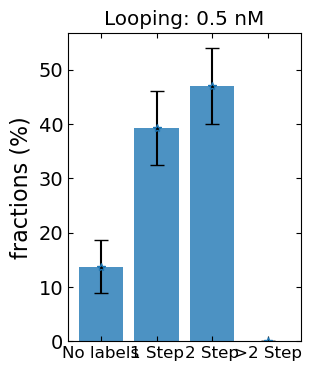

In [9]:
df_all = data_label_loop
df_filt_temp = df_all[df_all['folderpath'].notna()]
df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('_0p5nM')]
# df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_2|imgs_3|imgs_4)')]
df_filt_0p5nM = df_filt_temp

results = count_molecules_from_df_excel(df_filt_temp)
results_0p5nM = results # IMP rename the results

ax = barstat_err_plot(results['labels'], results['values'], results['total'], hatch=None)
ax.set_title('Looping: 0.5 nM')

N_tot, N_col, N_no_col, N_1bleaching, N_2bleaching, N_aggbleaching = results['total'], results['N_col'], results['N_no_col'], results['N_1bleaching'], results['N_2bleaching'], results['N_aggbleaching']
print(f'\
Number of total events::::::::::::::::::::::::::::::{N_tot}\n\
Number of events with colocalization::::::::::::::::{N_col}, ({round(N_col/N_tot, 2)})\n\
Number of events withut colocalization::::::::::::::{N_no_col}, ({round(N_no_col/N_tot, 2)})\n\
Number of events with 1 bleaching step (molecule):::{N_1bleaching}, ({round(N_1bleaching/N_tot, 2)})\n\
Number of events with 2 bleaching step (molecules)::{N_2bleaching}, ({round(N_2bleaching/N_tot, 2)})\n\
Number of events with >2 bleaching step (molecules):{N_aggbleaching}, ({round(N_aggbleaching/N_tot, 2)})\n\
')

In [10]:
results['values'] = np.array(results_0p5nM['values']) + np.array(results_2nM['values']) + np.array(results_5nM['values'])
results['total'] = results_0p5nM['total'] + results_2nM['total'] + results_5nM['total']
results['labels']

['No labels', '1 Step', '2 Step', '>2 Step']

In [11]:
results['total']

168

### Plot Bleaching Step fractions Vs Concentration

In [12]:
results_concs_list = [results_0p5nM, results_2nM, results_5nM]
total_steps = np.array([])
steps_0s = np.array([]); steps_0s_err = np.array([])
steps_1s = np.array([]); steps_1s_err = np.array([])
steps_2s = np.array([]); steps_2s_err = np.array([])
steps_aggs = np.array([]); steps_aggs_err = np.array([])
assert len(results['labels']) == 4
for res in results_concs_list:
    total_steps = np.append(total_steps, res['total'])
    vals = res['values']
    fractions, fractions_err = error_calc(res['values'], res['total'])
    fractions_err = fractions_err/100
    steps_0s = np.append(steps_0s, fractions[0]) #steps_0s.append(fractions[0])
    steps_0s_err = np.append(steps_0s_err, fractions_err[0])

    steps_1s = np.append(steps_1s, fractions[1])
    steps_1s_err = np.append(steps_1s_err, fractions_err[2])

    steps_2s = np.append(steps_2s, fractions[2])
    steps_2s_err = np.append(steps_2s_err, fractions_err[2])

    steps_aggs = np.append(steps_aggs, fractions[3])
    steps_aggs_err = np.append(steps_aggs_err, fractions_err[3])

labelling_eficiency = 0.7
step_theory_2 = labelling_eficiency ** 2
step_theory_1 = 2 * labelling_eficiency * (1-labelling_eficiency)
step_theory_0 = (1-labelling_eficiency) ** 2

In [13]:
print("compare step-0s: 0.5 Vs 2\n",
      stats.binomtest(int(steps_0s[0]*total_steps[0]), int(total_steps[0]), steps_0s[1]))
print("compare step-1s: 0.5 Vs 2\n",
      stats.binomtest(int(steps_1s[0]*total_steps[0]), int(total_steps[0]), steps_1s[1]))

compare step-0s: 0.5 Vs 2
 BinomTestResult(k=29, n=168, alternative='two-sided', proportion_estimate=0.17261904761904762, pvalue=0.6734406739275078)
compare step-1s: 0.5 Vs 2
 BinomTestResult(k=57, n=168, alternative='two-sided', proportion_estimate=0.3392857142857143, pvalue=0.6198362918458231)


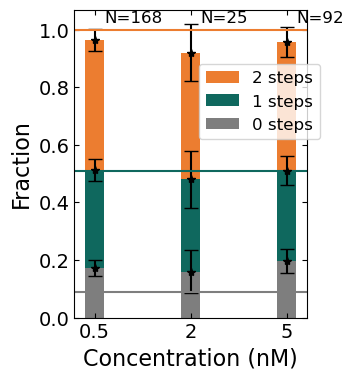

In [14]:
fig, ax = plt.subplots(figsize=(3,4))
colist = ['k', 'r', 'b']
colist = ['#7e7e7e', '#0f685e', '#ec7d30']

barWidth = 0.2
x_vals = np.array([0, 1, 2])
# x_vals = np.array([0.5, 2, 5])
conc_names = ['0.5', '2', '5']

plt.bar(x_vals, steps_0s, color=colist[0], width=barWidth, label='0 steps')
plt.errorbar(x_vals, steps_0s, yerr=steps_0s_err, color='black', fmt='*', capsize=5)
plt.axhline(step_theory_0, color=colist[0])

plt.bar(x_vals, steps_1s, bottom=steps_0s, color=colist[1], width=barWidth, label='1 steps')
plt.errorbar(x_vals, steps_1s+steps_0s, yerr=steps_1s_err, color='black', fmt='*', capsize=5)
plt.axhline(step_theory_1+step_theory_0, color=colist[1])

plt.bar(x_vals, steps_2s, bottom=steps_1s+steps_0s, color=colist[2], width=barWidth, label='2 steps')
plt.errorbar(x_vals, steps_2s+steps_1s+steps_0s, yerr=steps_2s_err, color='black', fmt='*', capsize=5)
plt.axhline(step_theory_0+step_theory_1+step_theory_2, color=colist[2])


plt.xticks(x_vals, conc_names)
plt.xlabel('Concentration (nM)')
plt.ylabel('Fraction')

steps_theory_all = [step_theory_0, step_theory_1, step_theory_2]
steps_theory_cumsum = [step_theory_0, step_theory_0+step_theory_1, step_theory_0+step_theory_1+step_theory_2]
for i, txt in enumerate(total_steps):
    plt.annotate('N='+str(int(txt)), (x_vals[i]+0.1, 1.025))
    plt.annotate(str(int(100*steps_theory_all[i]))+'%', (3, 0.02+steps_theory_cumsum[i]), color=colist[i])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='best', bbox_to_anchor=(0.5, 0.35, 0.5, 0.5))

plt.savefig(os.path.join(save_dir, 'step_fractions_vs_conc_barstacked.svg'))

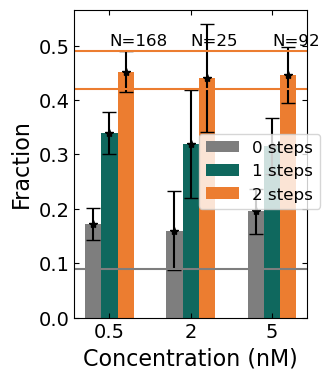

In [15]:
#Figure 2k
fig, ax = plt.subplots(figsize=(3,4))

plt.bar(x_vals-barWidth, steps_0s, color = colist[0], width = barWidth, label='0 steps')
plt.bar(x_vals, steps_1s, color = colist[1], width = barWidth, label='1 steps')
plt.bar(x_vals+barWidth, steps_2s, color = colist[2], width = barWidth, label='2 steps')

plt.errorbar(x_vals-barWidth, steps_0s, yerr=steps_0s_err, color='black', fmt='*', capsize=5)
plt.errorbar(x_vals, steps_1s, yerr=steps_1s_err, color='black', fmt='*', capsize=5)
plt.errorbar(x_vals+barWidth, steps_2s, yerr=steps_2s_err, color='black', fmt='*', capsize=5)

plt.axhline(step_theory_0, color = colist[0])
plt.axhline(step_theory_1, color = colist[2])
plt.axhline(step_theory_2, color=colist[2])

for i, txt in enumerate(total_steps):
    plt.annotate('N='+str(int(txt)), (x_vals[i], 0.5))
    plt.annotate(str(int(100*steps_theory_all[i]))+'%', (3, 0.01+steps_theory_all[i]))

plt.xticks(x_vals, conc_names)
plt.xlabel('Concentration (nM)')
plt.ylabel('Fraction')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.225, 0.5, 0.5));
plt.savefig(os.path.join(save_dir, 'step_fractions_vs_conc_bars.svg'))

error: [0.02915698 0.03652877 0.03840049 0.01311037]


C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3987387966.py:46: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax1, ax0)


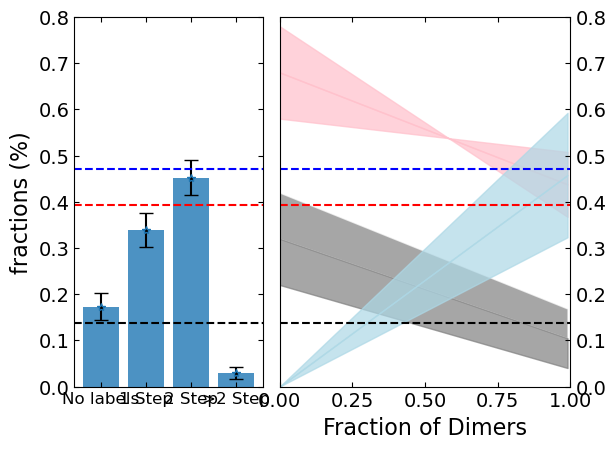

In [16]:
def Prob(x,le,le_err):
    """x: Fraction of Dimer, le: labeling efficiancy"""
    prob0= (1-le)**2 * x + (1-le)* (1-x)
    prob1 = 2* (1-le)*le *x + le *(1-x)
    prob2 = le**2 *x 
    prob0_err = np.sqrt((-2*(1-le) *x -1* (1-x))**2 * le_err**2)
    prob1_err = np.sqrt( ((2 - 4*le )*x + (1-x))**2 * le_err**2)
    prob2_err =  2*le*x * le_err
    return prob0,prob1,prob2,prob0_err,prob1_err,prob2_err

def Fraction(Prob2over1,le):
    x = 1/le * 1/(-1/le +2 + 1/Prob2over1)
    return x

fig = plt.figure()
ax0 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=3)

ax0 = barstat_err_plot(
    results['labels'], results['values'], results['total'], norm=1, ax=ax0, hatch=None)


x = np.arange(0,1,0.01)
le = 0.68
le_err = 0.1
Center = Prob(x,le,le_err)
# ax1.plot(x,Center[0], color = 'black')
ax1.fill_between(x,Center[0]+Center[3],Center[0], color = 'gray', ec='w', alpha=0.7)
ax1.fill_between(x,Center[0],Center[0]-Center[3], color = 'gray',alpha=0.7)
# ax1.plot(x,Center[1], color = 'red')
ax1.fill_between(x,Center[1]+Center[4],Center[1], color = 'pink',alpha=0.7)
ax1.fill_between(x,Center[1]-Center[4],Center[1], color = 'pink',alpha=0.7)
# ax1.plot(x,Center[2], color = 'blue')
ax1.fill_between(x,Center[2]+Center[5],Center[2], color = 'lightblue',alpha=0.7)
ax1.fill_between(x,Center[2],Center[2]-Center[5], color = 'lightblue',alpha=0.7)
ax1.axhline(y=N_no_col/N_tot, color='black', linestyle='dashed')
ax1.axhline(y=N_1bleaching/N_tot, color='red',linestyle='dashed')
ax1.axhline(y=N_2bleaching/N_tot, color='blue',linestyle='dashed')
ax0.axhline(y=N_no_col/N_tot, color='black', linestyle='dashed')
ax0.axhline(y=N_1bleaching/N_tot, color='red',linestyle='dashed')
ax0.axhline(y=N_2bleaching/N_tot, color='blue',linestyle='dashed')

ax1.set_xlim([0,1])
ax1.set_ylim([0,0.8])
ax0.set_ylim([0,0.8])
ax1.get_shared_y_axes().join(ax1, ax0)
ax1.yaxis.tick_right()
ax1.set_xlabel(r'Fraction of Dimers')
# ax1.set_ylabel(r'Probability')
# plt.show()

plt.savefig(os.path.join(save_dir, 'fractions_steps_all_with_theory.svg'))

error: [0.02915698 0.03652877 0.03840049 0.01311037]
error: [0.00286182 0.00493559 0.004999   0.        ]


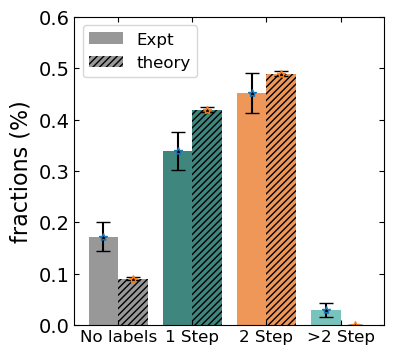

In [17]:
# Figure 2i
fig, ax = plt.subplots(figsize=(4,4))
color_list = ['#7e7e7e', '#0f685e', '#ec7d30', '#57b4ad']
barstat_err_plot(results['labels'], results['values'], results['total'], ax=ax,
                e_color=color_list,width=0.1, shift=-0.05, norm=1, hatch=None, label="Expt")

labelling_eficiency = 0.7
norm_tot = 10000
step_theory_2 = norm_tot*labelling_eficiency ** 2
step_theory_1 = norm_tot*2 * labelling_eficiency * (1-labelling_eficiency)
step_theory_0 = norm_tot*(1-labelling_eficiency) ** 2
step_theory_agg = 0
values = [step_theory_0, step_theory_1, step_theory_2, step_theory_agg]
barstat_err_plot(results['labels'], values, norm_tot, ax=ax,
                e_color=color_list, width=0.1, shift=0.05, norm=1, hatch="/////", label=f'theory')
ax.set_ylim(0, 0.6)
ax.legend()
plt.savefig(os.path.join(save_dir, 'fractions_stepst_all_with_theory_2nd.pdf'))

In [18]:
fractions, fractions_err = error_calc(results['values'], results['total'])
print(fractions)
print("No label Vs 1 step\n",
      stats.binomtest(results['values'][0], results['total'], fractions[1]))
print("1 Vs 2 step\n",
      stats.binomtest(results['values'][1], results['total'], fractions[2]))
print("2 Vs >2 step\n",
      stats.binomtest(results['values'][2], results['total'], fractions[3]))

[0.17261905 0.33928571 0.45238095 0.0297619 ]
No label Vs 1 step
 BinomTestResult(k=29, n=168, alternative='two-sided', proportion_estimate=0.17261904761904762, pvalue=1.822863659936362e-06)
1 Vs 2 step
 BinomTestResult(k=57, n=168, alternative='two-sided', proportion_estimate=0.3392857142857143, pvalue=0.0031707615169615294)
2 Vs >2 step
 BinomTestResult(k=76, n=168, alternative='two-sided', proportion_estimate=0.4523809523809524, pvalue=6.909999141929212e-69)


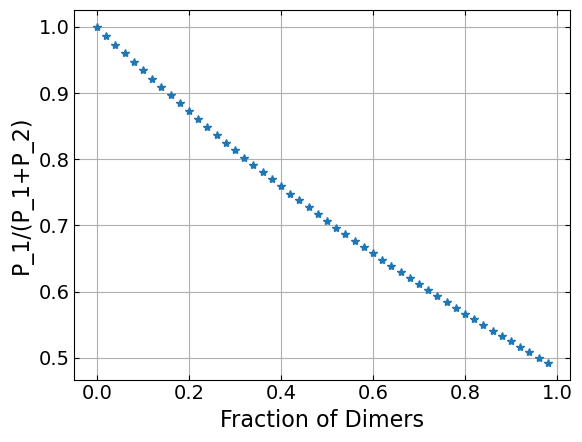

In [19]:
x = np.arange(0,1,0.02)
le = 0.68
le_err = 0.1
Center = Prob(x,le,le_err)

prob0,prob1,prob2,prob0_err,prob1_err,prob2_err = Center

total = prob2+prob1

total_error = prob1_err + prob2_err
ratio = prob1/total
ratio_error = ratio/total_error

plt.plot(x, ratio, '*')
# plt.fill_between(x, ratio+ratio_error,ratio, color = 'gray', ec='w', alpha=0.7)
# plt.fill_between(x, ratio-ratio_error,ratio, color = 'gray', ec='w', alpha=0.7)

plt.xlabel('Fraction of Dimers')
plt.ylabel('P_1/(P_1+P_2)')
plt.grid('minor')
# plt.yscale('log')
plt.savefig(os.path.join(save_dir, 'fractions_steps_NonLooping_theory.svg'))


## Duration Analysis
#### Experimental Outcome

length of 2 step events: 111


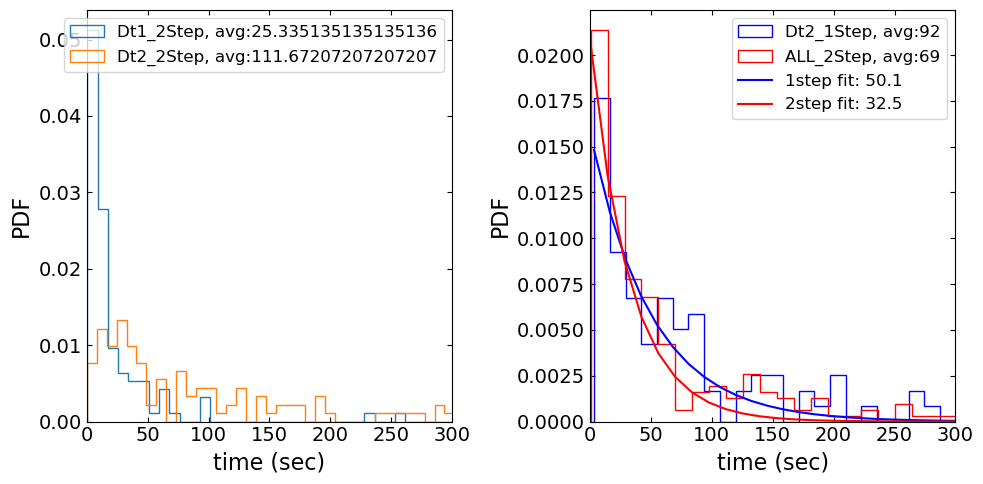

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
acq_time = 0.2 # in secs

# df_filt_temp = data_label_loop
df_all = data_label_loop
df_filt_temp = df_all[df_all['folderpath'].notna()]
# df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('_5nM"')]
# df_filt_temp = df_filt_temp[df_filt_temp['folderpath'].str.contains('(imgs_1|imgs_2|imgs_3|imgs_5)')]

df_label_loop_NO_molecules = df_filt_temp[df_filt_temp['co-localization protein and loop start?']=='no']
df_label_loop_molecules = df_filt_temp[df_filt_temp['how many molecules?'].notna()] # rows containing definite number of molecules
df_label_loop_1_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==1]
df_label_loop_2_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==2]
df_label_loop_agg_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?'] > 2]

Dt1_2step = df_label_loop_2_molecules.DeltaT1.dropna().values * acq_time
Dt2_2step = df_label_loop_2_molecules.DeltaT2.dropna().values * acq_time
All_2Step = np.vstack((Dt1_2step, Dt2_2step)).flatten()
# All_2Step = np.vstack((Dt1_2step, Dt2_2step-Dt1_2step)).flatten()
Dt2_1step = df_label_loop_1_molecules.DeltaT2.dropna().values * acq_time
print(f'length of 2 step events: {len(Dt1_2step)}')

_density = True
_log = False
# _bins = np.logspace(0.1, 3, 20)
_bins = 40

axs[0].hist(Dt1_2step, bins=40, histtype='step', density=_density, log=_log, label=f'Dt1_2Step, avg:{Dt1_2step.mean()}');
axs[0].hist(Dt2_2step-Dt1_2step, bins=40, histtype='step', density=_density, log=_log, label=f'Dt2_2Step, avg:{Dt2_2step.mean()}');
n_1, bins_1, _ = axs[1].hist(Dt2_1step, bins=_bins, histtype='step', color='b', density=_density, log=_log, label=f'Dt2_1Step, avg:{round(Dt2_1step.mean())}');
n_2, bins_2, _ = axs[1].hist(All_2Step, bins=_bins, histtype='step', color='r', density=_density, log=_log, label=f'ALL_2Step, avg:{round(All_2Step.mean())}');

# fit
myexp = lambda x,l,A:A*np.exp(-l*x)
# myexp = lambda x,l,A:A*(l*x)*np.exp(-l*x)

x = bins_1[:-1]
popt,pcov=curve_fit(myexp,xdata=x, ydata=n_1, p0=[1/70, 1])
axs[1].plot(x, myexp(x, *popt), color='b', label='1step fit: '+str(round(1/popt[0], 1)))

x = bins_2[:-1]
popt,pcov=curve_fit(myexp,xdata=x, ydata=n_2, p0=[1/70, 1])
axs[1].plot(x, myexp(x, *popt), color='r', label='2step fit: '+str(round(1/popt[0], 1)))

axs[0].set_xlabel('time (sec)')
axs[0].set_ylabel('PDF')
axs[0].legend();
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('PDF')
axs[1].legend();
# axs[0].set_xscale('log')
# axs[1].set_xscale('log')

axs[0].set_xlim(0, 300)
axs[1].set_xlim(0, 300);
fig.tight_layout()
plt.savefig(os.path.join(save_dir, 'time_distributions.svg'))

In [21]:
# np.savetxt("DeltaT_1step.csv", Dt2_1step, delimiter=",", fmt='%f')
# np.savetxt("DeltaT_2step.csv", All_2Step, delimiter=",", fmt='%f')

#### # Simulation

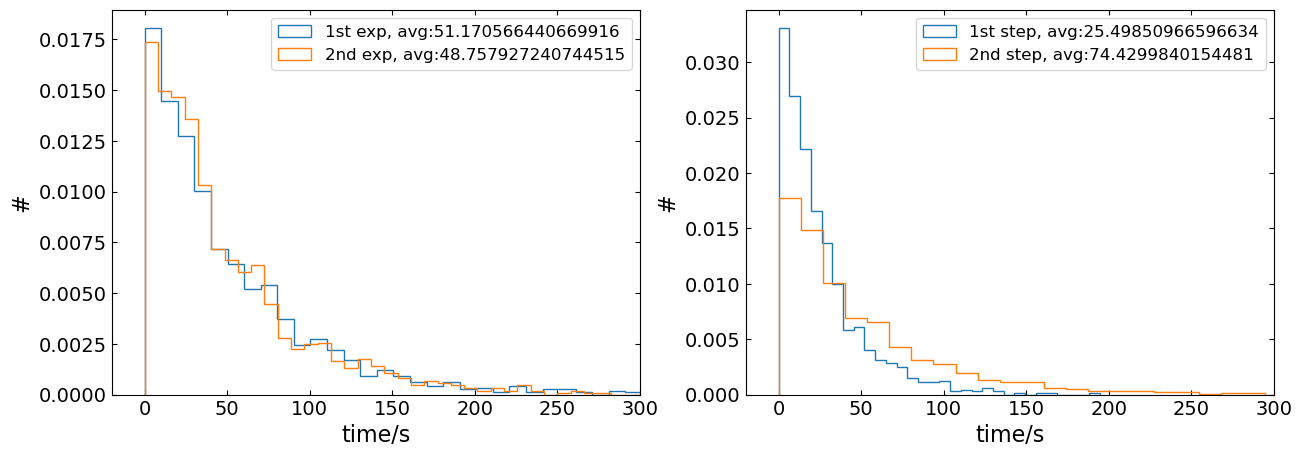

In [22]:
# Simulation
data_exp_1 = np.random.exponential(scale=50, size=1500)
data_exp_2 = np.random.exponential(scale=50, size=1500)
data_exp_combined = np.array([data_exp_1, data_exp_2]).T
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].hist(data_exp_1, bins=40, histtype='step', density=_density, label=f'1st exp, avg:{data_exp_1.mean()}');
axs[0].hist(data_exp_2, bins=40, histtype='step', density=_density, label=f'2nd exp, avg:{data_exp_2.mean()}');
axs[0].legend()
axs[0].set_xlabel('time/s')
axs[0].set_ylabel('#')

data_exp_combined.sort()
axs[1].hist(data_exp_combined[:,0], bins=30, histtype='step', density=_density, label=f'1st step, avg:{data_exp_combined[:,0].mean()}');
axs[1].hist(data_exp_combined[:,1]-data_exp_combined[:,0], bins=30, histtype='step', density=_density, label=f'2nd step, avg:{data_exp_combined[:,1].mean()}');
axs[1].set_xlabel('time/s')
axs[1].set_ylabel('#')

axs[0].set_xlim(None, 300)
axs[1].set_xlim(None, 300)

plt.legend();

array([ 8.69542758, 77.90092945])

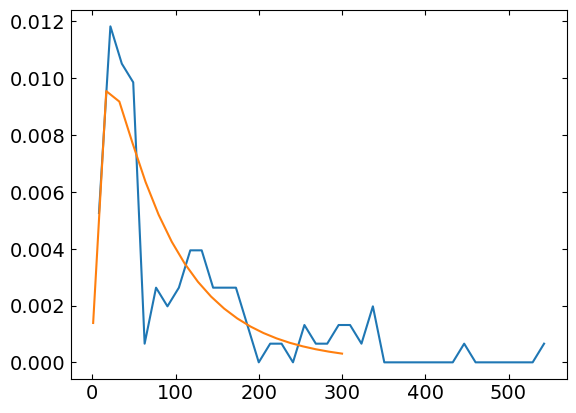

In [23]:
tau_1 = 30
tau_2 = 10
k1 = 1/tau_1
k2 = 1/tau_2
t = np.linspace(1, 300, 20)
p = (k1*k2/(k2-k1)) * (np.exp(-k1*t) - np.exp(-k2*t))

def two_bleaching_curve(t, k1, k2):
    return (k1*k2/(k2-k1)) * (np.exp(-k1*t) - np.exp(-k2*t))
a, b = np.histogram(Dt2_2step, bins=40, density=True)
# a, b = np.histogram(data_exp_combined[:,1], bins=40, density=True)
def two_bleaching_curve_Dt1(t, k1, k2):
    return (k1*k2/(k2+k1)) * (np.exp(-k1*t) + np.exp(-k2*t))

b= b[:-1]
popt, pcov = curve_fit(two_bleaching_curve, xdata=b, ydata=a, p0=(0.033, 0.01))
plt.plot(b, a)
plt.plot(t, two_bleaching_curve(t, *popt))
# plt.plot(t, two_bleaching_curve_Dt1(t, *popt))
# plt.plot(t, two_bleaching_curve(t, k1, k2))
1/popt

In [24]:
# 2nM analysis
df_label_loop_fpath_noNaN = data_label_loop[data_label_loop['folderpath'].notna()]
df_label_loop_2nM = df_label_loop_fpath_noNaN[df_label_loop_fpath_noNaN['folderpath'].str.contains('0p5nM')]# Choose the conc here


df_label_loop_NO_molecules = df_label_loop_2nM[df_label_loop_2nM['co-localization protein and loop start?']=='no']
df_label_loop_molecules = df_label_loop_2nM[df_label_loop_2nM['how many molecules?'].notna()] # rows containing definite number of molecules
df_label_loop_1_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==1]
df_label_loop_2_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?']==2]
df_label_loop_agg_molecules = df_label_loop_molecules[df_label_loop_molecules['how many molecules?'] > 2]

N_tot = len(df_label_loop_molecules) + len(df_label_loop_NO_molecules)
N_no_col = len(df_label_loop_NO_molecules)
N_col = len(df_label_loop_molecules)
N_1bleaching = len(df_label_loop_1_molecules)
N_2bleaching = len(df_label_loop_2_molecules)
N_aggbleaching = len(df_label_loop_agg_molecules)

print(f'\
Number of total events::::::::::::::::::::::::::::::{N_tot}\n\
Number of events with colocalization::::::::::::::::{N_col}, ({round(N_col/N_tot, 2)})\n\
Number of events withut colocalization::::::::::::::{N_no_col}, ({round(N_no_col/N_tot, 2)})\n\
Number of events with 1 bleaching step (molecule):::{N_1bleaching}, ({round(N_1bleaching/N_tot, 2)})\n\
Number of events with 2 bleaching step (molecules)::{N_2bleaching}, ({round(N_2bleaching/N_tot, 2)})\n\
Number of events with >2 bleaching step (molecules):{N_aggbleaching}, ({round(N_aggbleaching/N_tot, 2)})\n\
')

Number of total events::::::::::::::::::::::::::::::51
Number of events with colocalization::::::::::::::::44, (0.86)
Number of events withut colocalization::::::::::::::7, (0.14)
Number of events with 1 bleaching step (molecule):::20, (0.39)
Number of events with 2 bleaching step (molecules)::24, (0.47)
Number of events with >2 bleaching step (molecules):0, (0.0)



length of 2 step events: 24


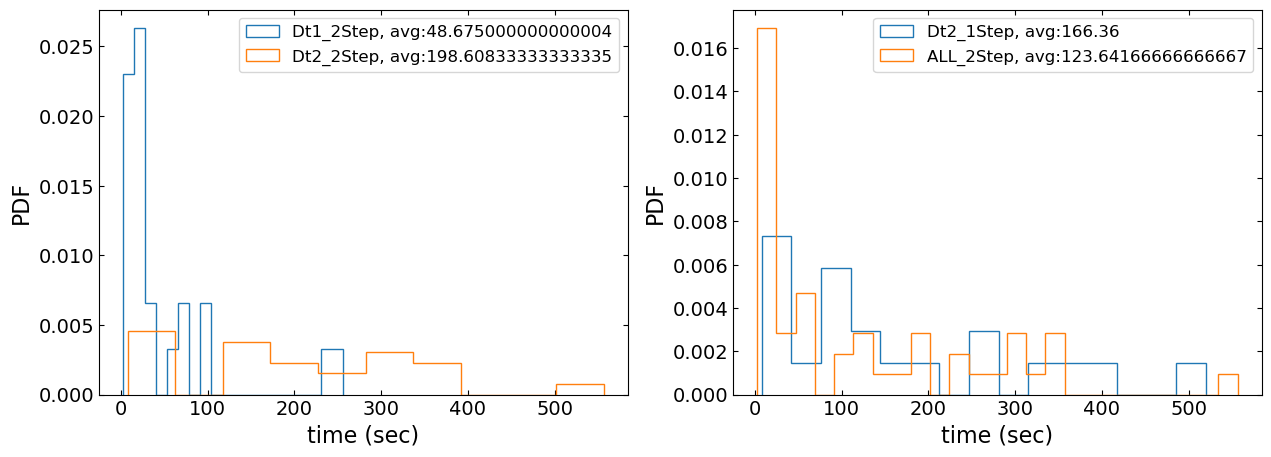

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
acq_time = 0.2 # in secs
Dt1_2step = df_label_loop_2_molecules.DeltaT1.dropna().values * acq_time
Dt2_2step = df_label_loop_2_molecules.DeltaT2.dropna().values * acq_time
All_2Step = np.vstack((Dt1_2step, Dt2_2step)).flatten()
Dt2_1step = df_label_loop_1_molecules.DeltaT2.dropna().values * acq_time
print(f'length of 2 step events: {len(Dt1_2step)}')

_density = True
axs[0].hist(Dt1_2step, bins=20, histtype='step', density=_density, label=f'Dt1_2Step, avg:{Dt1_2step.mean()}');
axs[0].hist(Dt2_2step, bins=10, histtype='step', density=_density, label=f'Dt2_2Step, avg:{Dt2_2step.mean()}');
axs[1].hist(Dt2_1step, bins=15, histtype='step', density=_density, label=f'Dt2_1Step, avg:{Dt2_1step.mean()}');
axs[1].hist(All_2Step, bins=25, histtype='step', density=_density, label=f'ALL_2Step, avg:{All_2Step.mean()}');

axs[0].set_xlabel('time (sec)')
axs[0].set_ylabel('PDF')
axs[0].legend();
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('PDF')
axs[1].legend();

# axs[0].set_xlim(None, 300)
# axs[1].set_xlim(None, 300);

## Labeled SMC5/6 at Non-Loops

In [26]:
data_label_nonloop = excel_all_data_label.parse('Nse4SNAP_Alexa640_NonLoop')
data_label_nonloop = data_label_nonloop[data_label_nonloop['Name'].notna()]
data_label_nonloop.head()

,Name,X,Y,W,H,binding at end?,translocating?,how many molecules?,binding steps,bleaching steps,duration/frames,frame range,directional,MSDanalysis,comments,folderpath,Rate
0,loop,1.65781,12.711597,6.296547,4.352076,yes,no,1.0,1.0,1.0,930.0,3040-3970,NaN,NaN,NaN,NaN,NaN
1,loop (2),1.65781,12.711597,6.296547,4.352076,no,yes,1.0,1.0,1.0,120.0,170-290,NaN,NaN,NaN,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN
2,loop (2),1.65781,12.711597,6.296547,4.352076,yes,no,1.0,2.0,2.0,270.0,240-510,NaN,NaN,NaN,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN
3,loop (2),1.65781,12.711597,6.296547,4.352076,yes,no,1.0,1.0,1.0,400.0,670-1070,NaN,NaN,NaN,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN
4,loop (2),1.65781,12.711597,6.296547,4.352076,yes,no,1.0,1.0,1.0,180.0,1560-1740,NaN,NaN,NaN,20220310_Nse4SNAPAlexa647NoSEC_600mV_5nM_imgs_6,NaN


### Bleaching steps fractions: plot

Number of total events: 100
Number of 1 binding steps: 76
Number of 2 binding steps: 24
Number of 1 binding 1 bleaching steps: 70
Number of 1 binding 2 bleaching steps: 6

error: [3.09317333 3.09317333 0.        ]


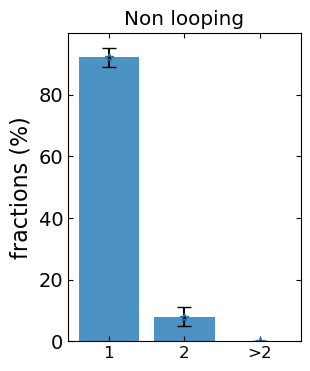

In [27]:
df_1bindstep = data_label_nonloop[data_label_nonloop['binding steps']==1]
df_2bindstep = data_label_nonloop[data_label_nonloop['binding steps']==2]
df_1bindstep_1bleachingstep = df_1bindstep[df_1bindstep['bleaching steps']==1]
df_1bindstep_2bleachingstep = df_1bindstep[df_1bindstep['bleaching steps']==2]
df_1bindstep_agg = df_1bindstep[df_1bindstep['bleaching steps']>2]
print(f'\
Number of total events: {len(data_label_nonloop)}\n\
Number of 1 binding steps: {len(df_1bindstep)}\n\
Number of 2 binding steps: {len(df_2bindstep)}\n\
Number of 1 binding 1 bleaching steps: {len(df_1bindstep_1bleachingstep)}\n\
Number of 1 binding 2 bleaching steps: {len(df_1bindstep_2bleachingstep)}\n\
')
labels = ['1', '2', '>2']
values = [len(df_1bindstep_1bleachingstep), len(df_1bindstep_2bleachingstep), len(df_1bindstep_agg)]
total = len(df_1bindstep)
ax = barstat_err_plot(labels, values, total, hatch=None)

values = [len(df_1bindstep_1bleachingstep), len(df_1bindstep_2bleachingstep), len(df_1bindstep_agg)]

ax.set_title('Non looping')
plt.savefig(os.path.join(save_dir, 'BleachingStepsNonLooping.svg'))

In [28]:
fractions, fractions_err = error_calc(values, total, norm=1)
fractions
stats.binomtest(values[0], total, p=fractions[1])

BinomTestResult(k=70, n=76, alternative='two-sided', proportion_estimate=0.9210526315789473, pvalue=8.753539018032238e-70)

In [29]:
df_1bindstep_end = df_1bindstep[df_1bindstep['binding at end?']=='yes']
df_1bindstep_end = df_1bindstep_end[df_1bindstep_end['bleaching steps']==1]
Dt = df_1bindstep_end['duration/frames'].dropna().values * 0.2 # in secs
print(f'Average bleaching time for endbinding molecules with 1 binding step and 1 bleaching step: {round(Dt.mean(), 2)} s')

Average bleaching time for endbinding molecules with 1 binding step and 1 bleaching step: 67.94 s


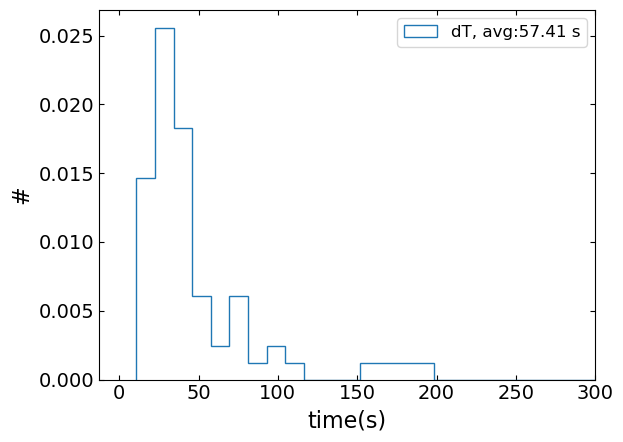

In [30]:
acq_time = 0.2 # in secs
Dt2_astep = df_1bindstep_1bleachingstep['duration/frames'].values * acq_time
_density = True
plt.hist(Dt2_astep, bins=40, histtype='step', density=_density, label=f'dT, avg:{round(Dt2_astep.mean(), 2)} s');
plt.xlabel('time(s)')
plt.ylabel('#')
plt.xlim(None, 300)
plt.legend();

Number of binding at ends: 27
Number of binding at ends and translocating: 5
Number of binding at Non-ends: 73
Number of binding at Non-ends and translocating: 67

error: [7.47567989 7.47567989]
error: [3.21461329 3.21461329]


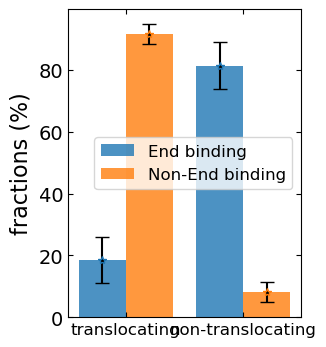

In [31]:
df_binding_at_end = data_label_nonloop[data_label_nonloop['binding at end?']=='yes']
df_binding_at_end_and_translocating = df_binding_at_end[df_binding_at_end['translocating?']=='yes']

df_binding_at_nonend = data_label_nonloop[data_label_nonloop['binding at end?']!='yes']
df_binding_at_nonend_and_translocating = df_binding_at_nonend[df_binding_at_nonend['translocating?']=='yes']

print(f'\
Number of binding at ends: {len(df_binding_at_end)}\n\
Number of binding at ends and translocating: {len(df_binding_at_end_and_translocating)}\n\
Number of binding at Non-ends: {len(df_binding_at_nonend)}\n\
Number of binding at Non-ends and translocating: {len(df_binding_at_nonend_and_translocating)}\n\
')

labels = ['translocating', 'non-translocating']
total = len(df_binding_at_end)
values = [len(df_binding_at_end_and_translocating), total-len(df_binding_at_end_and_translocating)]
ax = barstat_err_plot(labels, values, total, width=0.1, shift=-0.1/2, label='End binding', hatch=None)

labels = ['translocating', 'non-translocating']
total = len(df_binding_at_nonend)
values = [len(df_binding_at_nonend_and_translocating), total-len(df_binding_at_nonend_and_translocating)]
ax = barstat_err_plot(labels, values, total,ax=ax, width=0.1, shift=+0.1/2, label='Non-End binding', hatch=None)
plt.legend()

### directional: translocation

Number of total events: 45
Number of Non-directiol: 8
Number of Mono directional: 34
Number of Bi- directional: 3

error: [5.69937306 6.40644394 3.71848901]


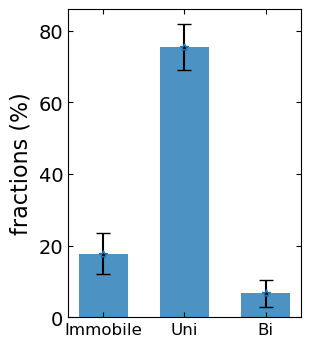

In [32]:
df_directional = data_label_nonloop[data_label_nonloop['directional'].notna()]

df_non_dir = df_directional[df_directional['directional']==0]
df_mono_dir = df_directional[df_directional['directional']==1]
df_bi_dir = df_directional[df_directional['directional']==2]

print(f'\
Number of total events: {len(df_directional)}\n\
Number of Non-directiol: {len(df_non_dir)}\n\
Number of Mono directional: {len(df_mono_dir)}\n\
Number of Bi- directional: {len(df_bi_dir)}\n\
')

labels = ['Immobile', 'Uni', 'Bi']
total = len(df_directional)
values = [len(df_non_dir), len(df_mono_dir), len(df_bi_dir)]
ax = barstat_err_plot(labels, values, total, width=0.15, label='End binding', hatch=None)
plt.savefig(os.path.join(save_dir, 'TranslocationnDirectionFraction.svg'))

In [33]:
stats.binomtest(values[0], total, p=0.75)

BinomTestResult(k=8, n=45, alternative='two-sided', proportion_estimate=0.17777777777777778, pvalue=1.2276336414163413e-15)

## Fraction Loops Vs Concentration

### Labeled SMC56

In [34]:
df_loop_frac = excel_all_data_label.parse('Looping_fraction')
df_loop_frac = df_loop_frac[df_loop_frac['Filename'].notna()]
df_loop_frac.head(2)

,Filename,Concentration(nM),Loops,NonLoops,Sample,Comments
1,20220310_Nse4SNAPAlexa647_600mV_5nM_imgs_6,5.0,24.0,18.0,Nse4SNAP_Alexa647,NaN
2,20220312_Nse4SNAPAlexa640_5nM_new_imgs_1,5.0,17.0,74.0,Nse4SNAP_Alexa647,NaN


In [35]:
df_loop_frac_label = df_loop_frac[df_loop_frac['Sample'] == 'Nse4SNAP_Alexa647'] # select sample: label or wt
df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']
df_loop_frac_label_gb = df_loop_frac_label.groupby('Concentration(nM)')

concs = np.array(list(df_loop_frac_label_gb.groups.keys()))
df_loop_agg = df_loop_frac_label_gb['LoopFraction'].describe()
df_loop_agg

C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\555470044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\555470044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']


,count,mean,std,min,25%,50%,75%,max
Concentration(nM),,,,,,,,
0.0,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,6.0,0.042077,0.021264,0.014085,0.025025,0.047201,0.057858,0.064935
1.0,5.0,0.104507,0.065098,0.041096,0.066667,0.099567,0.103586,0.211618
2.0,3.0,0.293368,0.124796,0.159091,0.237154,0.315217,0.360507,0.405797
5.0,4.0,0.351365,0.161755,0.186813,0.269231,0.323609,0.405744,0.571429


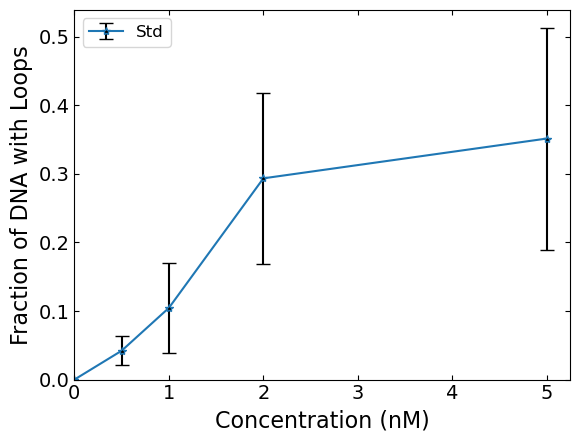

In [36]:
plt.errorbar(concs, df_loop_agg['mean'].values, yerr=df_loop_agg['std'].values, fmt='-*', capsize=5, ecolor='k', mfc='k', label='Std')
plt.xlim(0, )
plt.ylim(0, )
plt.xlabel('Concentration (nM)')
plt.ylabel('Fraction of DNA with Loops')
plt.legend()

### Wildtype

In [37]:
df_loop_frac_label = df_loop_frac[df_loop_frac['Sample'] == 'wildtype'] # select sample: label or wt
df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']
df_loop_frac_label_gb = df_loop_frac_label.groupby('Concentration(nM)')

concs = np.array(list(df_loop_frac_label_gb.groups.keys()))
df_loop_agg = df_loop_frac_label_gb['LoopFraction'].describe()
df_loop_agg
# fig, ax1 = plt.subplots()
# left, bottom, width, height = [0.475, 0.2, 0.4, 0.4]
# ax2 = fig.add_axes([left, bottom, width, height])

# ax1.errorbar(concs, df_loop_agg['mean'].values, yerr=df_loop_agg['std'].values, fmt='-*', capsize=5, ecolor='k', mfc='k', label='Std')
# bool = concs <= 1
# ax2.errorbar(concs[bool], df_loop_agg['mean'].values[bool], yerr=df_loop_agg['std'].values[bool], fmt='-*', capsize=5, ecolor='k', mfc='k', label='Std')

# ax1.set_xlim(0, )
# ax1.set_ylim(0, )
# ax1.set_xlabel('Concentration (nM)')
# ax1.set_ylabel('Fraction of DNA with Loops')
# ax1.legend();

# plt.savefig(os.path.join(save_dir, 'ConcVsLoopingFractionWildtype.svg'))

C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\1819007463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\1819007463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']


,count,mean,std,min,25%,50%,75%,max
Concentration(nM),,,,,,,,
0.00,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0.05,3.0,0.003721,0.001871,0.001845,0.002788,0.003731,0.004659,0.005587
0.10,2.0,0.003644,0.001712,0.002433,0.003038,0.003644,0.004249,0.004854
0.25,3.0,0.030337,0.007084,0.023109,0.026872,0.030635,0.033951,0.037267
0.50,3.0,0.073998,0.020625,0.051546,0.064944,0.078341,0.085223,0.092105
0.75,3.0,0.149799,0.025885,0.125313,0.136255,0.147196,0.162042,0.176887
1.00,3.0,0.239357,0.026028,0.209524,0.230322,0.251121,0.254273,0.257426
2.00,2.0,0.571126,0.069844,0.521739,0.546433,0.571126,0.595819,0.620513
3.00,3.0,0.732000,0.018542,0.712230,0.723499,0.734767,0.741886,0.749004


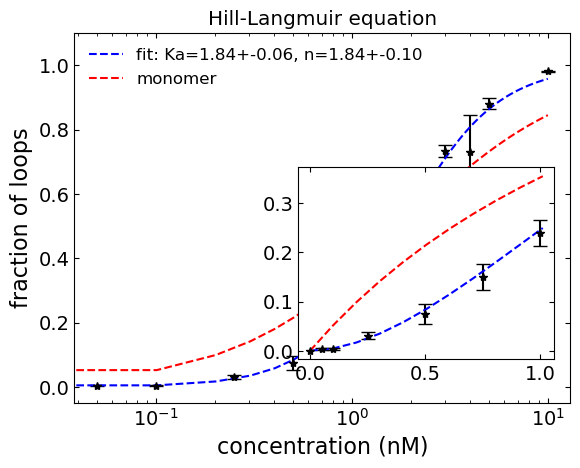

In [38]:
# Simulate Hills equation
# https://www.physiologyweb.com/calculators/index.html
# https://micropore.wordpress.com/2017/02/04/python-fit-with-error-on-y-axis/

def langmuir_hill(L, Ka, n):
    '''L: Ligand Concentration
    Ka: # nM conc at which half is associated
    '''
    return L**n / (Ka**n + L**n)

# Simulate
L_conc = np.linspace(0, 10, 100)
Ka = 2
# plt.plot(L_conc, langmuir_hill(L_conc, Ka=Ka, n=1), label='monomer')
# plt.plot(L_conc, langmuir_hill(L_conc, Ka=Ka, n=2), label='dimer')

##--------- fit -----------
L = concs
f = df_loop_agg['mean'].values
f_std = df_loop_agg['std'].values
popt, pcov = curve_fit(langmuir_hill, xdata=L, ydata=f)
Ka, n = popt

fig, ax1 = plt.subplots()
left, bottom, width, height = [0.475, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
L_sim = np.linspace(min(L), max(L), 100)
# ax1.plot(L, f, '*k')
ax1.errorbar(L, f, yerr=f_std, fmt='*k', capsize=5, ecolor='k', mfc='k')
ax1.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--',
         label=f'fit: Ka={popt[0]:.2f}+-{pcov[0,0]**0.5:.2f}, n={popt[1]:.2f}+-{pcov[1,1]**0.5:.2f}')
bool = L <= 1
bool_sim = L_sim<=1.1
ax2.errorbar(L[bool], f[bool], yerr=f_std[bool], fmt='*k', capsize=5, ecolor='k', mfc='k')
ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], *popt), 'b--')

ax1.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=1), 'r--', label='monomer')
ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], Ka=Ka, n=1), 'r--')

# ax1.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=2), 'm--', label='dimer')
# ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], Ka=Ka, n=2), 'm--')

# r = f - langmuir_hill(L, *popt)
# chisq = np.sum((r/f_std)**2) # get rid off non-zero std
# print(f'Chi squared: {chisq}')

ax1.set_xlabel('concentration (nM)')
ax1.set_ylabel('fraction of loops')
ax1.set_ylim(None, 1.1)
ax1.legend(loc='upper left', frameon=False);
ax1.set_title('Hill-Langmuir equation')
ax1.set_xscale('log')
plt.savefig(os.path.join(save_dir, 'ConcVsLoopingFractionWildtype.svg'))

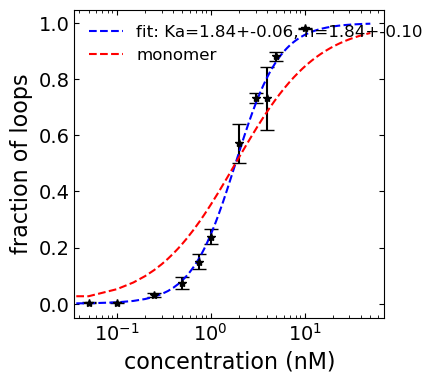

In [39]:

L_sim = np.linspace(min(L), 50, 1000)
plt.figure(figsize=(4,4))
plt.errorbar(L, f, yerr=f_std, fmt='*k', capsize=5, ecolor='k', mfc='k')
# plt.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--')
plt.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--',
         label=f'fit: Ka={popt[0]:.2f}+-{pcov[0,0]**0.5:.2f}, n={popt[1]:.2f}+-{pcov[1,1]**0.5:.2f}')
plt.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=1), 'r--', label='monomer')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('concentration (nM)')
plt.ylabel('fraction of loops')
plt.legend(loc='upper left', frameon=False)
plt.savefig(os.path.join(save_dir, 'ConcVsLoopingFractionWildtype.svg'))

### Hexamer

In [40]:
df_loop_frac_label = df_loop_frac[df_loop_frac['Sample'] == 'hexamer'] # select sample: label or wt
df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']
df_loop_frac_label_gb = df_loop_frac_label.groupby('Concentration(nM)')

concs = np.array(list(df_loop_frac_label_gb.groups.keys()))
df_loop_agg = df_loop_frac_label_gb['LoopFraction'].describe()
df_loop_agg


C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3953511221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['Total'] = df_loop_frac_label['Loops'] + df_loop_frac_label['NonLoops']
C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3953511221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_frac_label['LoopFraction'] = df_loop_frac_label['Loops']/df_loop_frac_label['Total']


,count,mean,std,min,25%,50%,75%,max
Concentration(nM),,,,,,,,
0.00,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
0.10,1.0,0.174312,NaN,0.174312,0.174312,0.174312,0.174312,0.174312
0.25,2.0,0.458105,0.054801,0.419355,0.438730,0.458105,0.477480,0.496855
0.50,1.0,0.927374,NaN,0.927374,0.927374,0.927374,0.927374,0.927374
1.00,1.0,0.986301,NaN,0.986301,0.986301,0.986301,0.986301,0.986301


C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\93348200.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return L**n / (Ka**n + L**n)


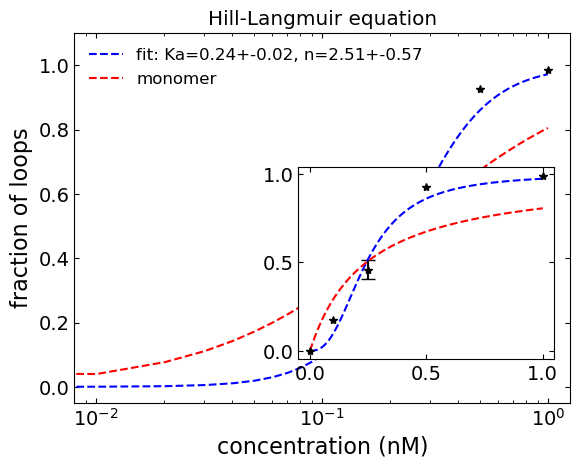

In [41]:
L = concs
f = df_loop_agg['mean'].values
f_std = df_loop_agg['std'].values
popt, pcov = curve_fit(langmuir_hill, xdata=L, ydata=f)
Ka, n = popt

fig, ax1 = plt.subplots()
left, bottom, width, height = [0.475, 0.2, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
L_sim = np.linspace(min(L), max(L), 100)
# ax1.plot(L, f, '*k')
ax1.errorbar(L, f, yerr=f_std, fmt='*k', capsize=5, ecolor='k', mfc='k')
ax1.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--',
         label=f'fit: Ka={popt[0]:.2f}+-{pcov[0,0]**0.5:.2f}, n={popt[1]:.2f}+-{pcov[1,1]**0.5:.2f}')
bool = L <= 1
bool_sim = L_sim<=1.1
ax2.errorbar(L[bool], f[bool], yerr=f_std[bool], fmt='*k', capsize=5, ecolor='k', mfc='k')
ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], *popt), 'b--')

ax1.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=1), 'r--', label='monomer')
ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], Ka=Ka, n=1), 'r--')

# ax1.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=2), 'm--', label='dimer')
# ax2.plot(L_sim[bool_sim], langmuir_hill(L_sim[bool_sim], Ka=Ka, n=2), 'm--')

# r = f - langmuir_hill(L, *popt)
# chisq = np.sum((r/f_std)**2) # get rid off non-zero std
# print(f'Chi squared: {chisq}')

ax1.set_xlabel('concentration (nM)')
ax1.set_ylabel('fraction of loops')
ax1.set_ylim(None, 1.1)
ax1.legend(loc='upper left', frameon=False);
ax1.set_title('Hill-Langmuir equation')
ax1.set_xscale('log')
plt.savefig(os.path.join(save_dir, 'ConcVsLoopingFractionWildtype.svg'))

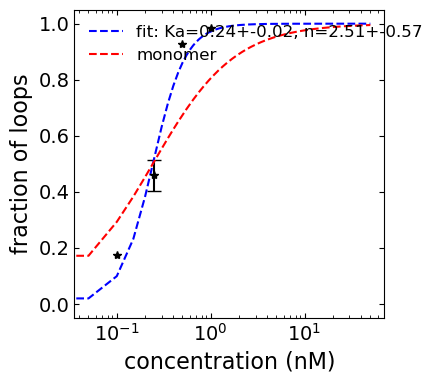

In [42]:
L_sim = np.linspace(min(L), 50, 1000)
plt.figure(figsize=(4,4))
plt.errorbar(L, f, yerr=f_std, fmt='*k', capsize=5, ecolor='k', mfc='k')
# plt.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--')
plt.plot(L_sim, langmuir_hill(L_sim, *popt), 'b--',
         label=f'fit: Ka={popt[0]:.2f}+-{pcov[0,0]**0.5:.2f}, n={popt[1]:.2f}+-{pcov[1,1]**0.5:.2f}')
plt.plot(L_sim, langmuir_hill(L_sim, Ka=Ka, n=1), 'r--', label='monomer')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('concentration (nM)')
plt.ylabel('fraction of loops')
plt.legend(loc='upper left', frameon=False)
plt.savefig(os.path.join(save_dir, 'ConcVsLoopingFractionHexamer.svg'))

## Hexamer vs Octamer: wildtype

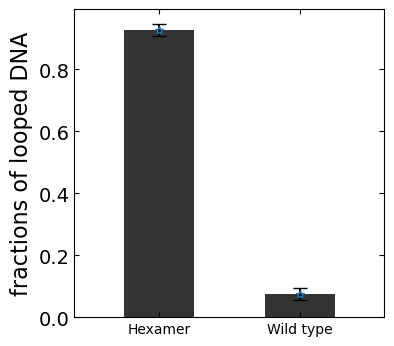

In [43]:
labels = ['Hexamer', 'Wild type']

# 0.25 nM
fractions = [0.46, 0.03]
fractions_err = [0.055, 0.01]

# 0.5 nM
ns56_total = 179
ns56_val = 166
nse56_fraction = 166/179
nse56_fraction_err =(1/ns56_total) * np.sqrt(ns56_total * nse56_fraction * (1 - nse56_fraction))
fractions = [nse56_fraction, 0.074]
fractions_err = [nse56_fraction_err, 0.02]

x_ticks = 0.25*np.arange(1, 1+len(labels))
shift = 0
width = 0.125
fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x_ticks+shift, fractions, width, color='k',alpha=0.8)
ax.errorbar(x_ticks+shift, fractions, yerr=fractions_err, fmt='*', capsize=5, ecolor='k', mfc='k', label='')


ax.set_xticks(x_ticks)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel('fractions of looped DNA')
ax.set_xlim(0.1, .65)
plt.savefig(os.path.join(save_dir, 'HexamerVsWildtyepLoopedFraction.svg'))

In [44]:
# https://www.nature.com/articles/s41592-021-01081-y
# https://www.pnas.org/doi/10.1073/pnas.1812734116
# https://www.science.org/doi/10.1126/science.abn6583
# https://www.science.org/action/downloadSupplement?doi=10.1126%2Fscience.abn6583&file=science.abn6583_sm.pdf

## DNA Length for Looped and NonLooped DNA

C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3391675002.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_sel['DnaLength'] = 0.11 * df_loop_sel['DnaLength'] / 16
C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\3391675002.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loop_sel['Name'] = 'loop'


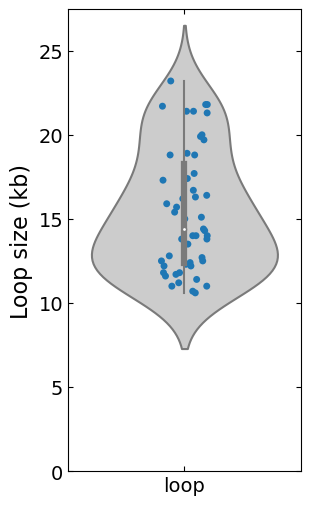

In [45]:
df_len_loop = excel_all_data_label.parse('DnaLengthLoops')
df_len_loop = df_len_loop[df_len_loop['Name'].notna()].reset_index(drop=True)
df_len_loop = df_len_loop[df_len_loop['Loop Size'].notna()].reset_index(drop=True)
df_loop_sel = df_len_loop[['Name', 'DnaLength', 'Loop Size']]
df_loop_sel['DnaLength'] = 0.11 * df_loop_sel['DnaLength'] / 16
df_loop_sel['Name'] = 'loop'

plt.figure(figsize=(3,6))
# ax = sns.violinplot(x=)
ax = sns.violinplot(x="Name", y="Loop Size" , data=df_loop_sel, color=".8")
# ax = sns.violinplot(x="day", y="total_bill", data=tips, color=".8")

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

sns.stripplot(x="Name", y="Loop Size", data=df_loop_sel, jitter=True, ax=ax)
ax.set_ylim(0, None)
ax.set_ylabel('Loop size (kb)')
ax.set_xlabel('')
plt.savefig(os.path.join(save_dir, 'dna_loopsizes_violinplot.svg'))

In [46]:
df_loop_sel['Loop Size'].describe()

count    51.000000
mean     15.450980
std       3.634137
min      10.600000
25%      12.350000
50%      14.400000
75%      18.250000
max      23.200000
Name: Loop Size, dtype: float64

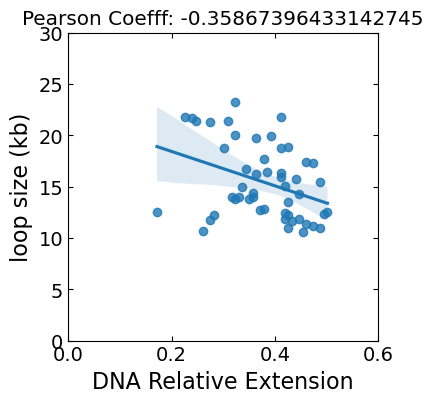

In [47]:
plt.figure(figsize=(4,4))
from scipy import stats
p_coeff, p = stats.pearsonr(df_loop_sel['DnaLength'], df_loop_sel['Loop Size'])

# ax = sns.scatterplot(x="DnaLength", y="Loop Size", data=df_loop_sel);
# ax = sns.lmplot(x="DnaLength", y="Loop Size", data=df_loop_sel);
sns.regplot(x=df_loop_sel["DnaLength"], y=df_loop_sel["Loop Size"])
# plt.scatter(df_loop_sel['DnaLength'], df_loop_sel['Loop Size'])



plt.xlabel('DNA Relative Extension')
plt.ylabel('loop size (kb)')

plt.xlim(0, 0.6)
plt.ylim(0, 30)
plt.title(f'Pearson Coefff: {p_coeff}')
plt.savefig(os.path.join(save_dir, 'dna_len_Vs_loopsizes.svg'))

,DnaLength,Loop Size
DnaLength,1.000000,-0.358674
Loop Size,-0.358674,1.000000


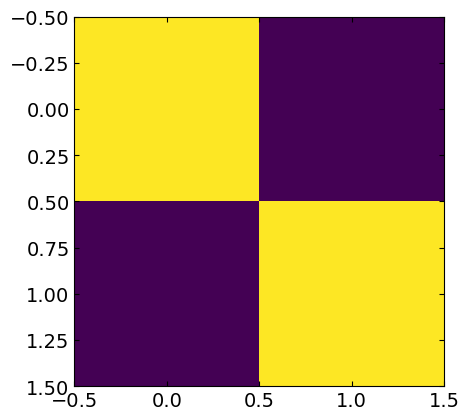

In [48]:
plt.imshow(df_loop_sel[['DnaLength', 'Loop Size']].corr())
df_loop_sel[['DnaLength', 'Loop Size']].corr()

C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\1076739947.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt_loop['Name'] = 'loop'
C:\Users\bipradha\AppData\Local\Temp\ipykernel_380\1076739947.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt_nonloop['Name'] = 'nonloop'


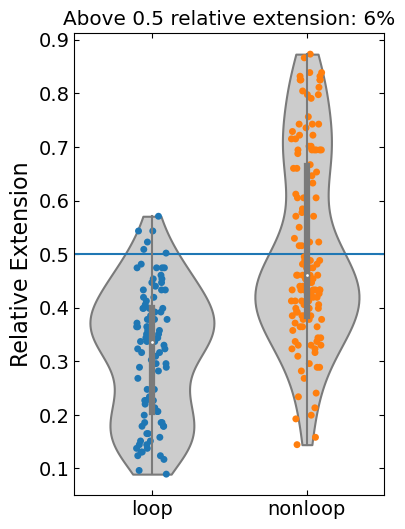

In [49]:
df_len_dna = excel_all_data_label.parse('DnaLength')
df_len_dna = df_len_dna[df_len_dna['Name'].notna()].reset_index(drop=True)
df_len_dna = df_len_dna[df_len_dna['DnaLength'].notna()].reset_index(drop=True)
df_len_dna['DnaLength'] = (0.110/16)*df_len_dna['DnaLength']

df_filt_loop = df_len_dna[df_len_dna['Name'].str.contains('loop')]
df_filt_loop['Name'] = 'loop'
df_filt_loop_rel0p5 = 100 * len(df_filt_loop[df_filt_loop['DnaLength']>0.5])/len(df_filt_loop)

df_filt_nonloop = df_len_dna[df_len_dna['Name'].str.contains('NonLoop')]


df_filt_nonloop['Name'] = 'nonloop'
df_len_all = pd.concat([df_filt_loop, df_filt_nonloop])

plt.figure(figsize=(4,6))
ax = sns.violinplot(x="Name", y="DnaLength" , data=df_len_all,cut=0, color=".8")
# ax = sns.violinplot(x="day", y="total_bill", data=tips, color=".8")

for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

sns.stripplot(x="Name", y="DnaLength", data=df_len_all, jitter=True, ax=ax)

ax.axhline(0.5)
ax.set_ylabel('Relative Extension')
ax.set_xlabel('')
ax.set_title(f'Above 0.5 relative extension: {round(df_filt_loop_rel0p5)}%')

plt.savefig(os.path.join(save_dir, 'dna_lentgh_violinplot.svg'))

In [50]:
# Figure 4a tests
stats.binomtest(int(0.08*752), 752, 0.005)

BinomTestResult(k=60, n=752, alternative='two-sided', proportion_estimate=0.0797872340425532, pvalue=1.1477368405904633e-50)

## Gel Assay

In [51]:
#Figure 1c
atp_no_dna = np.array([0.105, 0.084, 0.074])
atp_with_dna = np.array([1.526, 1.153, 1.901])
ke_atp_with_dna = np.array([0.003, 0.003, 0.004])
ke_atp_no_dna = np.array([0.009, 0.005, 0.008])

print("wt with and without DNA:\n",
      stats.ttest_1samp(atp_no_dna, atp_with_dna.mean()))
print("ke with DNA:\n",
      stats.ttest_1samp(ke_atp_with_dna, atp_with_dna.mean()))
print("ke with DNA:\n",
      stats.ttest_1samp(ke_atp_no_dna, atp_with_dna.mean()))

wt with and without DNA:
 Ttest_1sampResult(statistic=-157.52956732169127, pvalue=4.029485425884287e-05)
ke with DNA:
 Ttest_1sampResult(statistic=-4569.999999999999, pvalue=4.788148031246404e-08)
ke with DNA:
 Ttest_1sampResult(statistic=-1264.1617471972972, pvalue=6.257405549217067e-07)


In [52]:

excel_path_miki = "ATPase_Assays_MU.xlsx"
with pd.ExcelFile(excel_path_miki) as excel:
    print(excel.sheet_names)

['ATPase Fig.1b', 'ATPase Fig.1c', 'ATPase EDF.1c', 'ATPase EDF.1k', 'SEC plot holocomplex EDF. 1b', 'SEC plot hexamer EDF. 1f']


In [53]:
#Extended Figure 1k
with pd.ExcelFile(excel_path_miki):
    df_1k = pd.read_excel(excel_path_miki, sheet_name='ATPase EDF.1k')
holo_woDNA = df_1k.iloc[1, 1:5].values.astype(float)
holo_wDNA = df_1k.iloc[2, 1:5].values.astype(float)
hex_woDNA = df_1k.iloc[1, 5:8].values.astype(float)
hex_wDNA = df_1k.iloc[2, 5:8].values.astype(float)
pent_woDNA = df_1k.iloc[1, 8:11].values.astype(float)
pent_wDNA = df_1k.iloc[2, 8:11].values.astype(float)

print("holo with and without DNA:\n",
      stats.ttest_1samp(hex_woDNA, holo_wDNA.mean()))

# stats.ttest_1samp(holo_woDNA, holo_wDNA.mean())

holo with and without DNA:
 Ttest_1sampResult(statistic=-35.40571337426021, pvalue=0.0007967719007828238)
